In [1]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from scipy import optimize

%matplotlib inline

# start with 2 bodies vanilla WH
# add Inertial -> Cartesian transform (June 9)
# add kick! (interaction Hamiltonian)

# setup
# start with positions and velocities of 2 bodies
# r0 = (0, 0), v1 = (1, 0)
# r1 = (0, 1), v2 = (-1, 0)

# alg
# 0. Transform to Jacobian coordinates
# 1. Drift: advance system by half timestep h/2 by Keplerian part K
# 2. Kick: advance system by timestep h using R as Hamiltonian
# 3. Drift: repeat 1.
# 4. Repeat 1. to 3.

# G-functions (take in beta, X,...)

# f-g formulation of Keplerian motion (2-body motion)
# 1. calculate beta, eta_0, zeta_0
# 2. solve X from t(X) = h
# 3. solve f and g
# 4. solve new position and velocity from previous timestep using f and g

In [2]:
def drift(simj, object_num, h):
    """
    Advance (Keplerian part) system by timestep h
    
    Args:
        r::1D array
            Position (x, y)
        v::1D array
            Velocity (vx, vy)
        M::float
            Central mass
        h::float
            timestep

    Returns:
        r::float
            New position
        v::float
            New velocity
    """
    
    r = simj[object_num, :2]
    v = simj[object_num, 2:4]
    M = simj[0, 4] + simj[object_num, 4]
    
    r0 = np.sqrt(r[0]**2 + r[1]**2)
    r0i = 1./r0  #r0 inverse
    v2 = v[0]**2 + v[1]**2
    beta = 2*M*r0i - v2
    eta0 = r[0]*v[0] + r[1]*v[1]
    zeta0 = M - beta*r0

    # Solve Kepler's equation for X
    dtr0i = h * r0i # first order guess
    X_guess = dtr0i * (1 - dtr0i*eta0*0.5*r0i) # second order guess (according to Rebound)
    
    X = optimize.newton(func=Keplers_eqn, x0=X_guess, args=(r0, beta, eta0, zeta0, h))
    
    G1 = calculate_G(1, beta, X) 
    G2 = calculate_G(2, beta, X)
    G3 = calculate_G(3, beta, X)
    
    ri = 1./(r0 + eta0*G1 + zeta0*G2)
    f = 1 - M*G2*r0i
    g = h - M*G3
    fd = -M*G1*r0i*ri   # time derivative of f
    gd = 1 - M*G2*ri    # time derivative of g
    
    # solve for new position and velocity using the f and g functions
    rx = f*r[0] + g*v[0]
    ry = f*r[1] + g*v[1]
    vx = fd*r[0] + gd*v[0]
    vy = fd*r[1] + gd*v[1]

    simj[object_num, 0] = rx
    simj[object_num, 1] = ry
    simj[object_num, 2] = vx
    simj[object_num, 3] = vy

    return simj

def kick(sim, h):
    """
    Advance (Perturbation part) system by timestep h
    """
    
    # unpack simulation masses, positions and velocities
    m0 = sim[0, 4]
    m1 = sim[1, 4]
    m2 = sim[2, 4]
    
    r10_x = sim[0,0] - sim[1,0]
    r10_y = sim[0,1] - sim[1,1]
    r10_3 = np.sqrt(r10_x**2 + r10_y**2) ** 3
    
    r20_x = sim[0,0] - sim[2,0]
    r20_y = sim[0,1] - sim[2,1]
    r20_3 = np.sqrt(r20_x**2 + r20_y**2) ** 3
    
    r21_x = sim[1,0] - sim[2,0]
    r21_y = sim[1,1] - sim[2,1]
    r21_3 = np.sqrt(r21_x**2 + r21_y**2) ** 3
    
    r12_x = -r21_x
    r12_y = -r21_y
    r12_3 = np.sqrt(r12_x**2 + r12_y**2) ** 3
    
    # calculate perturbing acceleration in heliocentric coordinates
    
    A_helio = np.zeros((len(sim), 2))
    A_inertial = np.zeros((len(sim), 2))
    
    A_helio[1, 0] = -m2 * (r21_x/r21_3 - r20_x/r20_3)
    A_helio[1, 1] = -m2 * (r21_y/r21_3 - r20_y/r20_3)
    
    A_helio[2, 0] = -m1 * (r12_x/r12_3 - r10_x/r10_3)
    A_helio[2, 1] = -m1 * (r12_y/r12_3 - r10_y/r10_3)
    
    # convert perturbing acceleration to inertial coordinates
    # subtract centre of mass acceleration from each object's heliocentric accel.
        
    # heliocentric accelerations
    a1_x = -m0/r10_x**2 - m2/r12_x**2 
    a1_y = -m0/r10_y**2 - m2/r12_y**2 
    a2_x = -m0/r20_x**2 - m1/r21_x**2  
    a2_y = -m0/r20_y**2 - m1/r21_y**2 
    
    # heliocentric COM acceleration
    COM_ax = (m1*a1_x + m2*a2_x) / (m0 + m1 + m2)
    COM_ay = (m1*a1_y + m2*a2_y) / (m0 + m1 + m2)
    
    A_inertial[0, 0] = A_helio[0, 0] - COM_ax
    A_inertial[0, 1] = A_helio[0, 1] - COM_ay
    A_inertial[1, 0] = A_helio[1, 0] - COM_ax
    A_inertial[1, 1] = A_helio[1, 1] - COM_ay
    A_inertial[2, 0] = A_helio[2, 0] - COM_ax
    A_inertial[2, 1] = A_helio[2, 1] - COM_ay
    
    # kick the velocities by the perturbing acceleration
    sim[0, 2] += A_inertial[0, 0]*h
    sim[0, 3] += A_inertial[0, 1]*h
    sim[1, 2] += A_inertial[1, 0]*h
    sim[1, 3] += A_inertial[1, 1]*h
    sim[2, 2] += A_inertial[2, 0]*h
    sim[2, 3] += A_inertial[2, 1]*h
    
    return sim
    
def Keplers_eqn(X, r0, beta, eta0, zeta0, h):
    """
    Kepler's equation as described in eqn. (11) of Mikkola & Innanen 1999
    """
    term1 = r0 * X
    term2 = eta0 * calculate_G(2, beta, X)
    term3 = zeta0 * calculate_G(3, beta, X)
    return term1 + term2 + term3 - h

def calculate_G(n, beta, X):
    """
    G-functions as described in eqn. (9) of Mikkola & Innanen 1999
    """
    return X**n * calculate_c(n, beta*X**2)

def c(n, z, j):
    """
    Helper function to calculate_c
    """
    return (-z)**j / (math.factorial(n + 2*j))
    
def calculate_c(n, z):
    """
    c-functions as described in eqn. (7) of Mikkola & Innanen 1999
    """
    
    tolerance = 0.001 # stop expansion when adding the jth term changes c by less than tolerance
    j = 2 # number of terms in series expansion, after 0 and 1
    
    current_c = c(n, z, 0)
    next_c = current_c + c(n, z, 1)
    
    while (abs(current_c-next_c) > tolerance):
        current_c = next_c
        next_c += c(n, z, j)
        j += 1
        
    return next_c

def move_to_com(sim):
    """
    Convert from heliocentric to inertial centre-of-mass positions (not velocities)
    """
    
    r0 = sim[0, :2]
    m0 = sim[0, 4]
    r1 = sim[1, :2]
    m1 = sim[1, 4]
    r2 = sim[2, :2]
    m2 = sim[2, 4]
    
    COM_x = (m0*r0[0] + m1*r1[0] + m2*r2[0]) / (m0 + m1 + m2)
    COM_y = (m0*r0[1] + m1*r1[1] + m2*r2[1]) / (m0 + m1 + m2)
    
    r0[0] -= COM_x
    r0[1] -= COM_y
    r1[0] -= COM_x
    r1[1] -= COM_y
    r2[0] -= COM_x
    r2[1] -= COM_y

    sim[0, 0] = r0[0]
    sim[0, 1] = r0[1]
    sim[1, 0] = r1[0]
    sim[1, 1] = r1[1]
    sim[2, 0] = r2[0]
    sim[2, 1] = r2[1]
    
    return sim
    
def inertial_to_jacobi(sim):
    """
    Jacobi Coordinates: coordinates are measured relative to the COM of all inner bodies
    
    This follows transformations.c from Rebound, WHFast paper, and Mikkola & Innanen 1999
    """
    
    m0 = sim[0, 4]
    r0 = sim[0, :2]
    v0 = sim[0, 2:4]
    
    m1 = sim[1, 4]
    r1 = sim[1, :2]
    v1 = sim[1, 2:4]
    
    m2 = sim[2, 4]
    r2 = sim[2, :2]
    v2 = sim[2, 2:4]
    
    COM_x = m0 * r0[0]
    COM_y = m0 * r0[1]
    COM_vx = m0 * v0[0]
    COM_vy = m0 * v0[1]
    
    # Iterate over objects from inner planet to outer planet with a for loop
    r1j_x = r1[0] - COM_x/m0
    r1j_y = r1[1] - COM_y/m0
    v1j_x = v1[0] - COM_vx/m0
    v1j_y = v1[1] - COM_vy/m0
    
    COM_x = COM_x * (1+m1/m0) + m1*r1j_x
    COM_y = COM_y * (1+m1/m0) + m1*r1j_y
    COM_vx = COM_vx * (1+m1/m0) + m1*v1j_x
    COM_vy = COM_vy * (1+m1/m0) + m1*v1j_y
    
    r2j_x = r2[0] - COM_x/(m0+m1)
    r2j_y = r2[1] - COM_y/(m0+m1)
    v2j_x = v2[0] - COM_vx/(m0+m1)
    v2j_y = v2[1] - COM_vy/(m0+m1)
    
    COM_x = COM_x * (1+m2/(m0+m1)) + m2*r2j_x
    COM_y = COM_y * (1+m2/(m0+m1)) + m2*r2j_y
    COM_vx = COM_vx * (1+m2/(m0+m1)) + m2*v2j_x
    COM_vy = COM_vy * (1+m2/(m0+m1)) + m2*v2j_y
    
    # Set the Jacobi coordinate for the central object
    r0j_x = COM_x/(m0+m1+m2)
    r0j_y = COM_y/(m0+m1+m2)
    v0j_x = COM_vx/(m0+m1+m2)
    v0j_y = COM_vy/(m0+m1+m2)
    
    # Calculate Jacobi mass
    m0j = m0 + m1
    m1j = m0*m1 / (m0 + m1)
    m2j = m2*(m0+m1) / (m0 + m1 + m2)
    
    #m0j = m0 
    #m1j = m0 + m1
    #m2j = m0 + m1 + m2
    
    p0j = np.array([r0j_x, r0j_y, v0j_x, v0j_y, m0j])
    p1j = np.array([r1j_x, r1j_y, v1j_x, v1j_y, m1j])
    p2j = np.array([r2j_x, r2j_y, v2j_x, v2j_y, m2j])
    
    simj = np.stack([p0j, p1j, p2j])
    
    return simj

def jacobi_to_inertial(simj, sim):
    """
    reverse of inertial_to_jacobi
    """
    
    m0 = sim[0, 4]
    r0j = simj[0, :2]
    v0j = simj[0, 2:4]
    
    m1 = sim[1, 4]
    r1j = simj[1, :2]
    v1j = simj[1, 2:4]
    
    m2 = sim[2, 4]
    r2j = simj[2, :2]
    v2j = simj[2, 2:4]
    
    COM_x = r0j[0] * (m0+m1+m2)
    COM_y = r0j[1] * (m0+m1+m2)
    COM_vx = v0j[0] * (m0+m1+m2)
    COM_vy = v0j[1] * (m0+m1+m2)
    
    # Iterate over objects from outer planet to inner planet with a for loop
    COM_x = (COM_x - m2*r2j[0]) / (m0 + m1 + m2)
    COM_y = (COM_y - m2*r2j[1]) / (m0 + m1 + m2)
    COM_vx = (COM_vx - m2*v2j[0]) / (m0 + m1 + m2)
    COM_vy = (COM_vy - m2*v2j[1]) / (m0 + m1 + m2)
    
    r2_x = r2j[0] + COM_x
    r2_y = r2j[1] + COM_y
    v2_x = v2j[0] + COM_vx
    v2_y = v2j[1] + COM_vy
    
    COM_x *= m0 + m1
    COM_y *= m0 + m1
    COM_vx *= m0 + m1
    COM_vy *= m0 + m1
    
    COM_x = (COM_x - m1*r1j[0]) / (m0 + m1)
    COM_y = (COM_y - m1*r1j[1]) / (m0 + m1)
    COM_vx = (COM_vx - m1*v1j[0]) / (m0 + m1)
    COM_vy = (COM_vy - m1*v1j[1]) / (m0 + m1)
    
    r1_x = r1j[0] + COM_x
    r1_y = r1j[1] + COM_y
    v1_x = v1j[0] + COM_vx
    v1_y = v1j[1] + COM_vy
    
    COM_x *= m0
    COM_y *= m0 
    COM_vx *= m0
    COM_vy *= m0 
    
    # Set the inertial coordinate for the central object
    r0_x = COM_x/m0
    r0_y = COM_y/m0
    v0_x = COM_vx/m0
    v0_y = COM_vy/m0
    
    p0 = np.array([r0_x, r0_y, v0_x, v0_y, m0])
    p1 = np.array([r1_x, r1_y, v1_x, v1_y, m1])
    p2 = np.array([r2_x, r2_y, v2_x, v2_y, m2])
    
    sim = np.stack([p0, p1, p2])
    
    return sim

def energy_fn(sim):
    """ Calculate energy per unit mass as shown in p. 77 of Tremaine's book
    
    Args:
        sim::rebound.simulation.Simulation
            Rebound simulation object

    Returns:
        energy::float
            Energy per unit mass
    """
   
    e_kin = 0.
    e_pot = 0.
    
    for i in range(len(sim)):
        
        xi, yi = sim[i,0], sim[i,1]
        vxi, vyi, mi = sim[i,2], sim[i,3], sim[i,4]
        e_kin += 0.5 * m * (vxi**2 + vyi**2)
        
        for j in range(len(sim)):
            
            xj, yj, mj = sim[j,0], sim[j,1], sim[j,4]
        
            if i > j:
                dx = xi - xj
                dy = yi - yj
                e_pot += - sim.G * m / np.sqrt(dx*dx + dy*dy)
    
    return e_kin + e_pot


In [60]:
# initial conditions

# particle array as [rx, ry, vx, vy, m]
p0 = np.array([0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 1., 1e-3])
p2 = np.array([1.1, 0., 0., 0.7, 1e-3])
sim = np.stack([p0, p1, p2])

sim = move_to_com(sim)

timestep = 0.01
N_steps = 1000
# positions of 3 objects
orbit_soln = np.zeros((3, 2, N_steps))

start = time.time()

for i in range(N_steps):
    
    # drift
    simj = inertial_to_jacobi(sim)
    simj = drift(simj, object_num = 1, h=timestep/2)
    simj = drift(simj, object_num = 2, h=timestep/2)
    sim = jacobi_to_inertial(simj, sim)
    
    # kick
    #sim = kick(sim, h=timestep)
    
    # drift
    simj = inertial_to_jacobi(sim)
    simj = drift(simj, object_num = 1, h=timestep/2)
    simj = drift(simj, object_num = 2, h=timestep/2)
    sim = jacobi_to_inertial(simj, sim)

    #print(sim[2,0], sim[2,1])
    orbit_soln[0, 0, i], orbit_soln[0, 1, i] = sim[0,0], sim[0,1]
    orbit_soln[1, 0, i], orbit_soln[1, 1, i] = sim[1,0], sim[1,1]
    orbit_soln[2, 0, i], orbit_soln[2, 1, i] = sim[2,0], sim[2,1]
    
end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 0.4 s


2 jupiter mass planets on circular orbits at 1 and 2 au


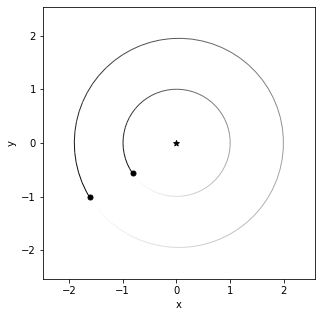

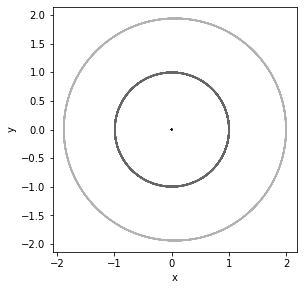

In [11]:
#M = 10

print('2 jupiter mass planets on circular orbits at 1 and 2 au')

fig, ax = rebound.OrbitPlot(sim)
#ax.axvline(-0.33, ls='--', label='x=-0.33')
#ax.axhline(0.58, ls='--', label='y=0.58')
#plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], alpha=0.9, c='black')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], alpha=0.6, c='black')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], alpha=0.3, c='black')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
#plt.legend(loc='lower right')
plt.show()

2 jupiter mass planets on circular orbits at 1 and 1.5 au


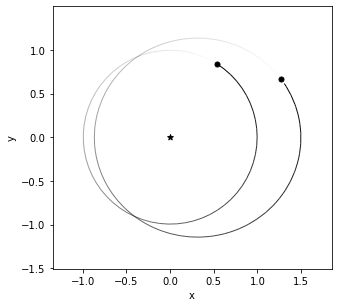

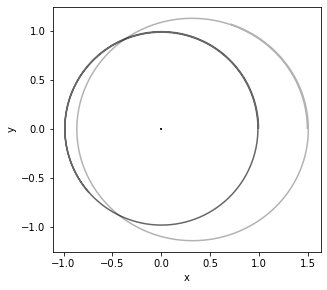

In [23]:
#M = 10

print('2 jupiter mass planets on circular orbits at 1 and 1.5 au')

fig, ax = rebound.OrbitPlot(sim)
#ax.axvline(-0.33, ls='--', label='x=-0.33')
#ax.axhline(0.58, ls='--', label='y=0.58')
#plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], alpha=0.9, c='black')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], alpha=0.6, c='black')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], alpha=0.3, c='black')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
#plt.legend(loc='lower right')
plt.show()

2 jupiter mass planets on circular orbits at 1 and 1.1 au


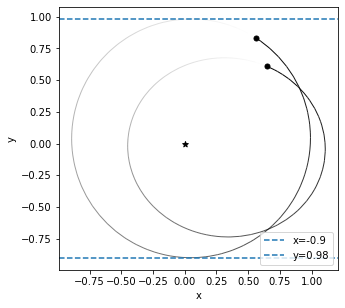

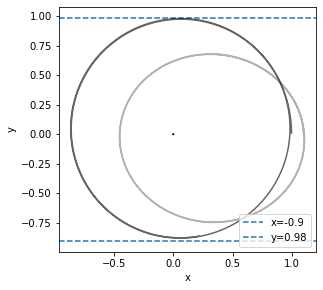

In [59]:
print('2 jupiter mass planets on circular orbits at 1 and 1.1 au')

fig, ax = rebound.OrbitPlot(sim)
ax.axhline(-0.9, ls='--', label='x=-0.9')
ax.axhline(0.98, ls='--', label='y=0.98')
plt.legend(loc='lower right')
plt.axis('scaled')
plt.show()

plt.figure(figsize=(10,4.5))
plt.axhline(-0.9, ls='--', label='x=-0.9')
plt.axhline(0.98, ls='--', label='y=0.98')
plt.plot(orbit_soln[0,0], orbit_soln[0,1], alpha=0.9, c='black')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], alpha=0.6, c='black')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], alpha=0.3, c='black')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.show()

2 jupiter mass planets on circular orbits at 1 and 1.1 au, no kick


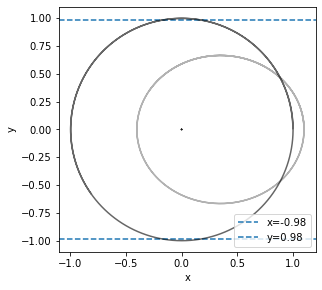

In [64]:
print('2 jupiter mass planets on circular orbits at 1 and 1.1 au, no kick')

plt.figure(figsize=(10,4.5))
plt.axhline(-0.98, ls='--', label='x=-0.98')
plt.axhline(0.98, ls='--', label='y=0.98')
plt.plot(orbit_soln[0,0], orbit_soln[0,1], alpha=0.9, c='black')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], alpha=0.6, c='black')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], alpha=0.3, c='black')
plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.show()

In [19]:
p0 = np.array([0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 1., 1e-3])
p2 = np.array([5., 0., 0., 1., 1e-3])
sim = np.stack([p0, p1, p2])

sim = move_to_com(sim)

print('sim before transform', sim[:,:2])

simj = inertial_to_jacobi(sim)

print('simj after transform', simj[:,:2])

sim = jacobi_to_inertial(simj, sim)

print('sim after transform back', sim[:,:2])

sim before transform [[-0.00598802  0.        ]
 [ 0.99401198  0.        ]
 [ 4.99401198  0.        ]]
simj after transform [[-8.65630477e-19  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00]
 [ 4.99900100e+00  0.00000000e+00]]
sim after transform back [[-0.00598802  0.        ]
 [ 0.99401198  0.        ]
 [ 4.99401198  0.        ]]


In [ ]:
sim = rebound.Simulation()

sim.add(m=1.)
sim.add(m=1., x=1., vy=1.)
sim.add(m=1., x=2., vy=1.)

sim.move_to_com()

print(sim.particles[0].x,sim.particles[0].y,sim.particles[1].x,sim.particles[1].y, sim.particles[2].x,sim.particles[2].y)

sim.particles[0].jacobi_com.x, sim.particles[0].jacobi_com.y, sim.particles[1].jacobi_com.x, sim.particles[1].jacobi_com.y, sim.particles[2].jacobi_com.x, sim.particles[2].jacobi_com.y
# sim.

In [47]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3, x=1., vy=1.)
sim.add(m=1e-3, x=1.1, vy=0.7)

sim.move_to_com()

sim.integrate(1) 


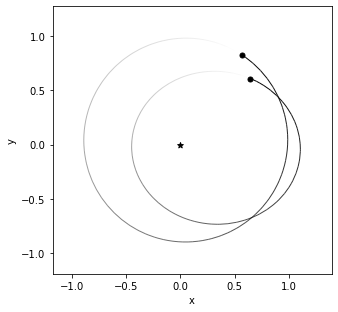

In [48]:
fig, ax = rebound.OrbitPlot(sim)

#plt.legend(loc='lower right')
#plt.axis('scaled')
plt.show()

In [42]:
help(rebound.OrbitPlot)

Help on function OrbitPlot in module rebound.plotting:

OrbitPlot(sim, figsize=None, fancy=False, slices=0, xlim=None, ylim=None, unitlabel=None, color=False, periastron=False, orbit_type='trail', lw=1.0, plotparticles=None, primary=None, Narc=128)
    Convenience function for plotting instantaneous orbits.
    
    Parameters
    ----------
    sim             : Simulation
    figsize         : tuple of float, optional
        Tuple defining the figure size (default: (5,5))
    fancy           : bool (default: False)
        Changes various settings to create a fancy looking plot
    slices          : float, optional
        Default is 0, showing the orbits in the xy plane only. Set to a value between 0 and 1 to create three plots, showing the orbits from different directions. The value corresponds to the size of the additional plots relative to the main plot.
    xlim            : tuple of float, optional           
        Limits for x axes (default: None = automatically determined)